# Facteur de Forme

## Technique de résolution de Monte Carlo

[**R1:** Les indices utilisés pour les tracés "uniforme, cellule carrée" ne sont pas explicites, uniformiser le titre des graphiques]

### Technique de résolution de Monte Carlo

- Soit Ri, Rj deux patchs
- On détermine le facteur de forme Fij entre les surfaces Ri et Rj

\begin{equation*}
F_{ij} = \frac{A_j}{n} \sum_{k=1}^n \frac{cos(\theta_i) cos(\theta_j)}{2\pi r^2 + \frac{A_j}{n}}
\end{equation*}

- Fij = Aj/n * ∑(1 à n) (cos θi cos θj)/( 2π*r^2 + Aj/n)

- Ai, Aj l'aire des patchs Ri et Rj
- n le nombre de points pris sur rj (et sur ri)
- θi et θj, l'angle entre le rayon rij et la normale aux surfaces
- r la norme du vecteur rij

- Note: dAj approximé par un disque

#### Algorithme général

- Fij <- 0
- boucle sur le nombre de rayons voulus 
    - sélection de deux points, xi et xj, placés sur la surface des 2 patchs Ri et Rj
    - calcul du vecteur Rij (le rayon émis) et normalisation
    - calcul delta F pour ce rayon
    - Fij += delta F
- Fij = Aj/n * Fij

### Fonctions

#### Incrément entre 2 valeurs du nombre d'itérations testées (helper)

In [31]:
getDeltaFromNbIter <- function(l) {
  delta <- 1
  if (l>100000) {delta <- 10000}
  else if (l>10000) {delta <- 1000}
  else if (l>1000) {delta <- 500}
  else if (l>100) {delta <- 100}
  else if (l>10 && l<100) { delta <- 10 }
  return(delta)
}

gcd <- function(a,b){
  if (abs(b-0)<1e-7) {
    pgs <- a
  }
  else {
    r <- a%%b
    pgs <- gcd(b,r)
  }
  return(pgs)
}
print("DEBUG - Adaptative step based on current iterations: OK")

[1] "DEBUG - Adaptative step based on current iterations: OK"


## Rectangle opposé à Rectangle

- Deux rectangles de dimensions identiques opposés et parallèles, séparés par la distance d (sur axe z)
- Ri Receveur, dans le plan (xOy) a sur x, b sur y
- Rj Emetteur, parallèle à Ri a sur x, b sur y

### Résolution théorique

In [32]:
getAnalyticSolution <- function(a, b, c) {
  # Fij Théorique entre 2 faces rectangulaires identiques et parallèles (parallèle au plan (xOy)) et séparée par une distance de lz
  X = a/c
  Y = b/c
  
  th_fij = 2/(pi*X*Y)*( log(sqrt( ((1+X^2)*(1+Y^2))/(1+X^2+Y^2) ))
                        + X*sqrt(1+Y^2)*atan(X/sqrt(1+Y^2))
                        + Y*sqrt(1+X^2)*atan(Y/sqrt(1+X^2))
                        - X*atan(X) - Y*atan(Y) )
  msg <- sprintf("Analytic Fij = %e", th_fij)
  print(msg)
  return(th_fij)
}
print("Analytic solution 2 parallel rectangles of the same dimensions facing each other along y axis: OK")

[1] "Analytic solution 2 parallel rectangles of the same dimensions facing each other along y axis: OK"


### Monte Carlo: Echantillonage aléatoire par ray casting

Ici, les 2 points xi et xj sont placés aléatoirement sur chacune des surfaces Ri, Rj.

In [53]:
compute_random <- function(a, b, c, th_fij, eaper, n, outiter, newgraph) {
  #data <- build_shapes(a, b, c)
  
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(a, b, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- a*b
  
  rj_min <- c(0., 0., c)
  rj_max <- c(a, b, c)
  rj_norm <- c(0., 0., -1.)
  aj <- a*b
  
  if (is.nan(th_fij)) {
    th_fij <- getAnalyticSolution(a, b, c)
  }
  
  mtitle <- sprintf("Monte Carlo area-area rnd sampling R//R (a, b, c: %.1f, %.1f, %.1f ; S: %.1f)", a, b, c, (a*b))
  
  if (newgraph) {
    # graph y [-eaper ; eaper]
    plot(0,, type="n", xlim=c(0., n), xlab="iterations", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)
  }
  
  
  for (m in 1:outiter) {
    #  for (l in seq(1, n, by = steps)) {
    l <- 0
    delta <- 1
    while(l < n) {
      l <- l + delta
      delta <- getDeltaFromNbIter(l)
      fij <- 0.
      for (k in 1:l) {
        xi <- c(runif(1, ri_min[1], ri_max[1]), runif(1, ri_min[2], ri_max[2]), ri_min[3])
        xj <- c(runif(1, rj_min[1], rj_max[1]), runif(1, rj_min[2], rj_max[2]), rj_min[3])
        rij <- xj - xi
        r2 <- sum(rij^2)
        
        nrij <- rij/sqrt(r2)
        costhetai <- sum(ri_norm * nrij)
        costhetaj <- sum(rj_norm * -nrij) # dans le cas //, costhetai = costhetaj
        
        df = ( (costhetai*costhetaj) / (pi*r2 + aj/l))
        if (df > 0) {
          fij <- fij + df
        } else {
          print("df < 0")
        }
      }
      fij <- fij * aj/l
      points(x=l, y= ((fij - th_fij)/th_fij)*100., pch=4, col="red")
    }
    msg <- sprintf("rnd (n=%d) Fij=%e", n, fij)
    print(msg)
  }  
}
print("MC Random Sampling Emitter x Receiver (n x n): OK")

[1] "MC Random Sampling Emitter x Receiver (n x n): OK"


[1] "Analytic Fij = 1.998249e-01"
[1] "rnd (n=5000) Fij=1.999137e-01"
[1] "rnd (n=5000) Fij=1.994489e-01"
[1] "rnd (n=5000) Fij=1.999172e-01"


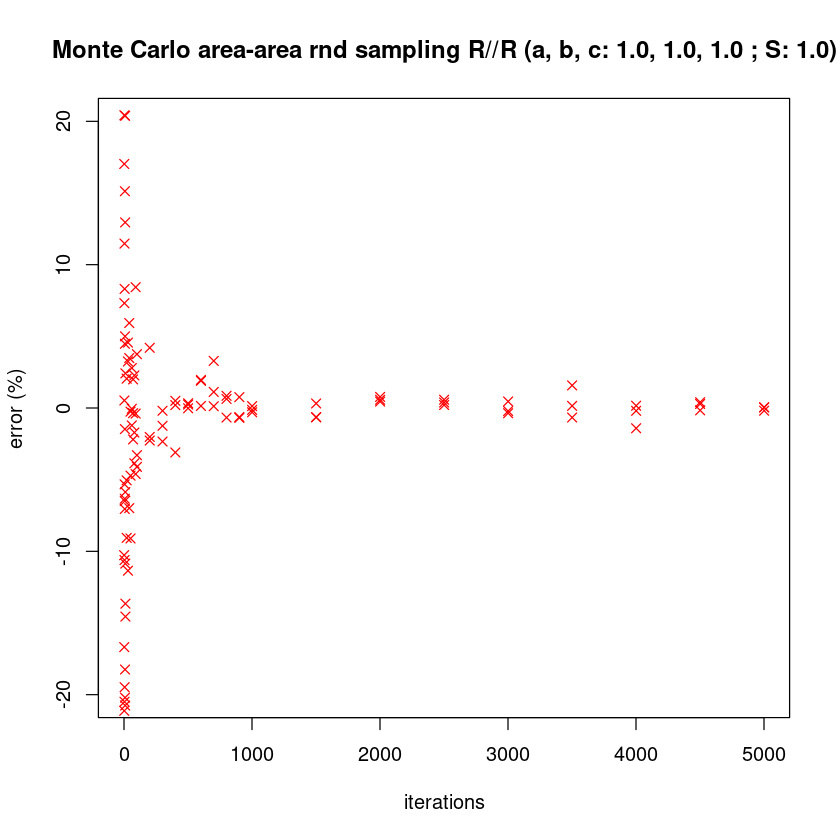

In [54]:
# a, b, c, analytic fij (Nan), graph max perc., nb iter, nb runs, 1:display new graph
compute_random(1., 1., 1., NaN, 20, 5000, 3, 1)

### Monte Carlo: Découpage des surfaces en cellules uniforme

- La technique est la même sauf la définition des points
- la surface des rectangles Ri et Rj est subdivisée en cellule sur leurs deux axes pour obtenir k x k surfaces. Chaque cellule conserve le ratio longueur/largeur du rectangle intial 
- le centre de chaque surface est le point de départ (ou d'arrivée) des rayons
- un rayon est émis de chaque cellule du récepteur vers chaque cellule de l'émetteur

In [55]:
compute_uniform_innerloop <- function(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits, pcolor="darkgreen") {
  
  nbsplits <- (hsplits * vsplits)^2
  dx <- a/hsplits
  dy <- b/vsplits
  x0 <- dx/2.
  y0 <- dy/2.
  
  fij <- 0
  # on ri.y
  for (miy in 0:(vsplits-1)) {
    ciy = y0 + miy * dy
    # on ri.x
    for (mix in 0:(hsplits-1)) {
      xi <- c(x0+mix*dx, ciy, ri_min[3])

      # on rj.y
      for (mjy in 0:(vsplits-1)) {
        cjy = y0 + mjy * dy
        # on rj.x
        for (mjx in 0:(hsplits-1)) {
          xj <- c(x0+mjx*dx, cjy, rj_min[3])
          #cat("xj: ", xj,"\n")
          rij <- xj - xi
          r2 <- sum(rij^2)
          
          nrij <- rij/sqrt(r2)
          costhetai <- sum(ri_norm * nrij)
          costhetaj <- sum(rj_norm * -nrij) # dans le cas //, costhetai = costhetaj
          
          df = ( (costhetai*costhetaj) / (pi*r2 + aj/(hsplits * vsplits)))
          if (df > 0) {
            fij <- fij + df
          } else {
            print("df < 0")
          }
          
        }
      }
      
    }
  }
  fij <- fij * aj / nbsplits
  msg <- sprintf("grid (%d x %d : %d) Fij=%e", hsplits, vsplits, nbsplits, fij)
  print(msg)
  
  points(x=nbsplits, y= ((fij - th_fij)/th_fij)*100., pch=18, col=pcolor)
  text(nbsplits, ((fij - th_fij)/th_fij)*100., labels=hsplits, cex= 0.7, pos=3)
}
  

compute_uniform <- function(a, b, c, th_fij, eaper, maxsplits, newgraph) {
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(a, b, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- a*b
  
  rj_min <- c(0., 0., c)
  rj_max <- c(a, b, c)
  rj_norm <- c(0., 0., -1.)
  aj <- a*b
  
  if (is.nan(th_fij)) {
    th_fij <- getAnalyticSolution(a, b, c)
  }
  
  if (newgraph) {
      mtitle <- sprintf("Monte Carlo area-area uni. sampling R//R (a, b, c: %.1f, %.1f, %.1f ; S: %.1f)", a, b, c, (a*b))
    plot(0, type="n", xlim=c(0., maxsplits^4), xlab="splits", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)
  }
  
  for (m in 1:maxsplits) {
    hsplits <- m
    vsplits <- m

    compute_uniform_innerloop(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits)
  }
    

  abline(h=0., col="black", lty=3)
}
print("MC Uniform Sampling Emitter x Receiver (k^4): OK")

[1] "MC Uniform Sampling Emitter x Receiver (k^4): OK"


[1] "Analytic Fij = 1.998249e-01"
[1] "grid (1 x 1 : 1) Fij=2.414530e-01"
[1] "grid (2 x 2 : 16) Fij=2.030604e-01"
[1] "grid (3 x 3 : 81) Fij=2.008973e-01"
[1] "grid (4 x 4 : 256) Fij=2.003684e-01"
[1] "grid (5 x 5 : 625) Fij=2.001557e-01"
[1] "grid (6 x 6 : 1296) Fij=2.000483e-01"
[1] "grid (7 x 7 : 2401) Fij=1.999863e-01"
[1] "grid (8 x 8 : 4096) Fij=1.999471e-01"
[1] "grid (9 x 9 : 6561) Fij=1.999207e-01"
[1] "grid (10 x 10 : 10000) Fij=1.999021e-01"


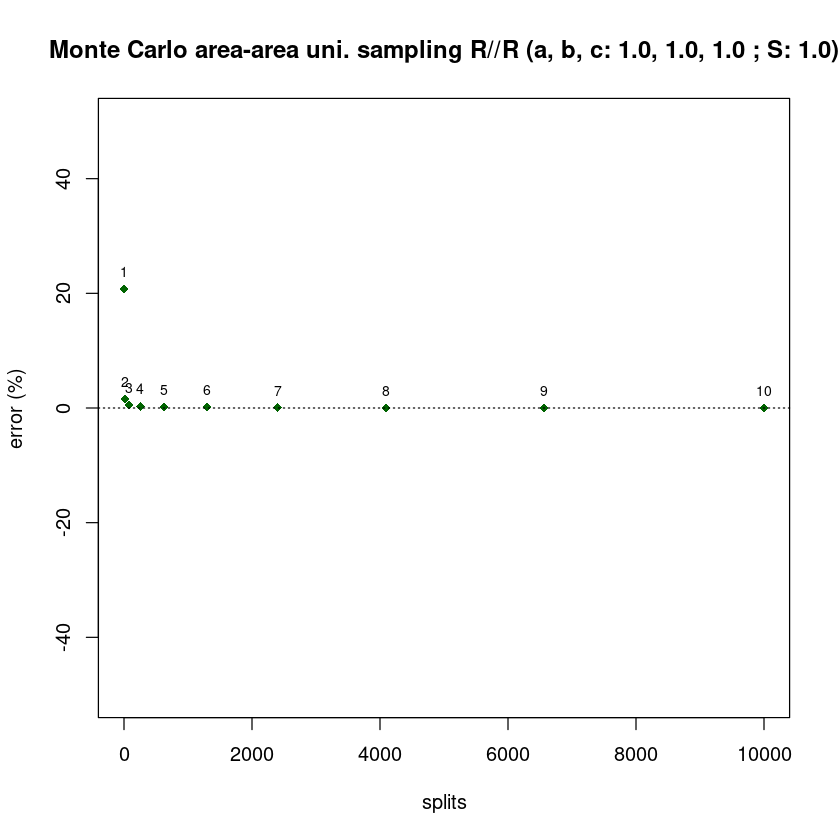

In [56]:
# a, b, c, th fij (Nan), graph max perc., k (hsplit, vsplit on both shape), 1: new graph
compute_uniform(1., 1., 1., NaN, 50, 10, 1)

### Monte Carlo: Découpage des surfaces en cellules carrées

- "Approximation" des dAj par des disques pour le calcul de Fij
- On cherche à savoir si utiliser des cellules carrées accélère la convergence de la méthode

- Soit L la longuer d'un rectangle R et l sa largeur
- Soit c la longueur du coté d'un carré
- Si k et k' sont le nombre de répétition du carré de coté c dans la longueur et la largeur de R
- On peut découper R avec des carrés c de sorte que

\begin{equation*}
\frac{k}{k'} = u \frac{L}{l}
\end{equation*}

- on calcule p le pgcd de (a, b) pour simplifier la fraction L/l puis on divise la surface en carré c
- les points xi et xj seront les centres des carrés obtenus


In [59]:
compute_uniform_gcd <- function(a, b, c, th_fij, eaper, u, newgraph, pcolor="darkgreen") {
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(a, b, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- a*b
  
  rj_min <- c(0., 0., c)
  rj_max <- c(a, b, c)
  rj_norm <- c(0., 0., -1.)
  aj <- a*b
  
  if (is.nan(th_fij)) {
    th_fij <- getAnalyticSolution(a, b, c)
  }
  
  p <- gcd(a, b)
  hs <- a / p
  vs <- b / p
  
  if (newgraph) {
    mtitle <- sprintf("Monte Carlo area-area uni. sqr. sampling R//R (a, b, c: %.1f, %.1f, %.1f ; S: %.1f)", a, b, c, (a*b))
    plot(0, type="n", xlim=c(0., (hs*vs*u*u)^2), xlab="splits", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)
  }
  
  
  for (v in 1:u) {
    hsplits <- v*hs
    vsplits <- v*vs
    #cat("(",v," p: ", p, "hs: ", hs, "vs: ", vs, "hsplits: ",hsplits, "vsplits: ", vsplits, "\n")
    
    compute_uniform_innerloop(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits, pcolor)
    #if (p == 1) { break }
  }

  abline(h=0., col="black", lty=3)
}
print("MC Uniform Sampling Emitter / Receiver with square cells (hi x vi)^2: OK")

[1] "MC Uniform Sampling Emitter / Receiver with square cells (hi x vi)^2: OK"


[1] "Analytic Fij = 1.998249e-01"
[1] "grid (1 x 1 : 1) Fij=2.414530e-01"
[1] "grid (2 x 2 : 16) Fij=2.030604e-01"
[1] "grid (3 x 3 : 81) Fij=2.008973e-01"
[1] "grid (4 x 4 : 256) Fij=2.003684e-01"
[1] "grid (5 x 5 : 625) Fij=2.001557e-01"
[1] "grid (6 x 6 : 1296) Fij=2.000483e-01"
[1] "grid (7 x 7 : 2401) Fij=1.999863e-01"
[1] "grid (8 x 8 : 4096) Fij=1.999471e-01"
[1] "grid (9 x 9 : 6561) Fij=1.999207e-01"
[1] "grid (10 x 10 : 10000) Fij=1.999021e-01"


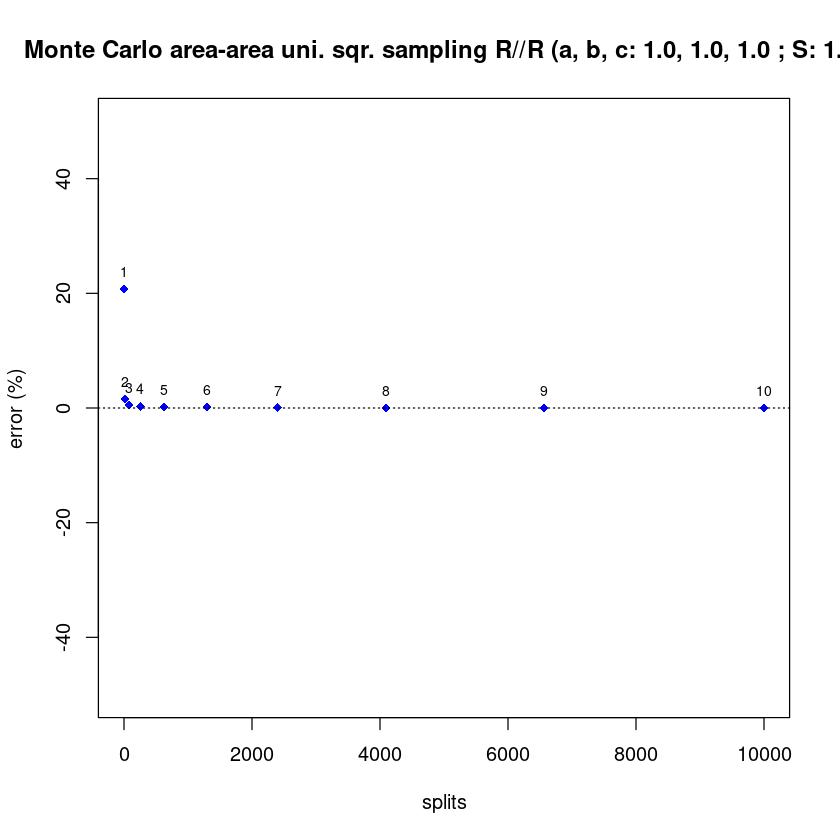

In [60]:
# a, b, c, th fij (Nan), graph max perc., k (hsplit, vsplit on both shape), 1: new graph
compute_uniform_gcd(1., 1., 1., NaN, 50, 10, 1, pcolor="blue")

In [61]:
go_para <- function(a, b, c, n, eaper=50, r=3) {
    compute_random(a, b, c, NaN, eaper, n, r, 1)
    k = as.integer(n^(1/4))
    compute_uniform(a, b, c, NaN, eaper, k, 0)
    compute_uniform_gcd(a, b, c, NaN, eaper, k, 0, pcolor="blue")
    randommsg <- sprintf("random sampling emitter x receiver [n=%d, %d run(s)]", n, r)
    uni1msg <- sprintf("uniform sampling emitter x receiver [k^4=%d]", k^4)
    uni2msg <- sprintf("uniform sampling emitter / receiver (square cells) [(hixvi)*(hjxvj), u=%d]", k)
    legend("topright", legend=c(randommsg, uni1msg, uni2msg),
         col=c("red", "darkgreen", "blue"), pch=c(4,18,15), cex=0.8, inset=0.01)
}

[1] "Analytic Fij = 3.591665e-01"
[1] "rnd (n=10000) Fij=3.656325e-01"
[1] "rnd (n=10000) Fij=3.558562e-01"
[1] "rnd (n=10000) Fij=3.621409e-01"
[1] "Analytic Fij = 3.591665e-01"
[1] "grid (1 x 1 : 1) Fij=6.141305e-01"
[1] "grid (2 x 2 : 16) Fij=4.916903e-01"
[1] "grid (3 x 3 : 81) Fij=4.118206e-01"
[1] "grid (4 x 4 : 256) Fij=3.762640e-01"
[1] "grid (5 x 5 : 625) Fij=3.629981e-01"
[1] "grid (6 x 6 : 1296) Fij=3.586767e-01"
[1] "grid (7 x 7 : 2401) Fij=3.575431e-01"
[1] "grid (8 x 8 : 4096) Fij=3.574346e-01"
[1] "grid (9 x 9 : 6561) Fij=3.576073e-01"
[1] "grid (10 x 10 : 10000) Fij=3.578254e-01"
[1] "Analytic Fij = 3.591665e-01"
[1] "grid (5 x 1 : 25) Fij=3.685599e-01"
[1] "grid (10 x 2 : 400) Fij=3.544456e-01"
[1] "grid (15 x 3 : 2025) Fij=3.567074e-01"
[1] "grid (20 x 4 : 6400) Fij=3.577207e-01"
[1] "grid (25 x 5 : 15625) Fij=3.582230e-01"
[1] "grid (30 x 6 : 32400) Fij=3.585044e-01"
[1] "grid (35 x 7 : 60025) Fij=3.586771e-01"
[1] "grid (40 x 8 : 102400) Fij=3.587903e-01"
[1] "grid 

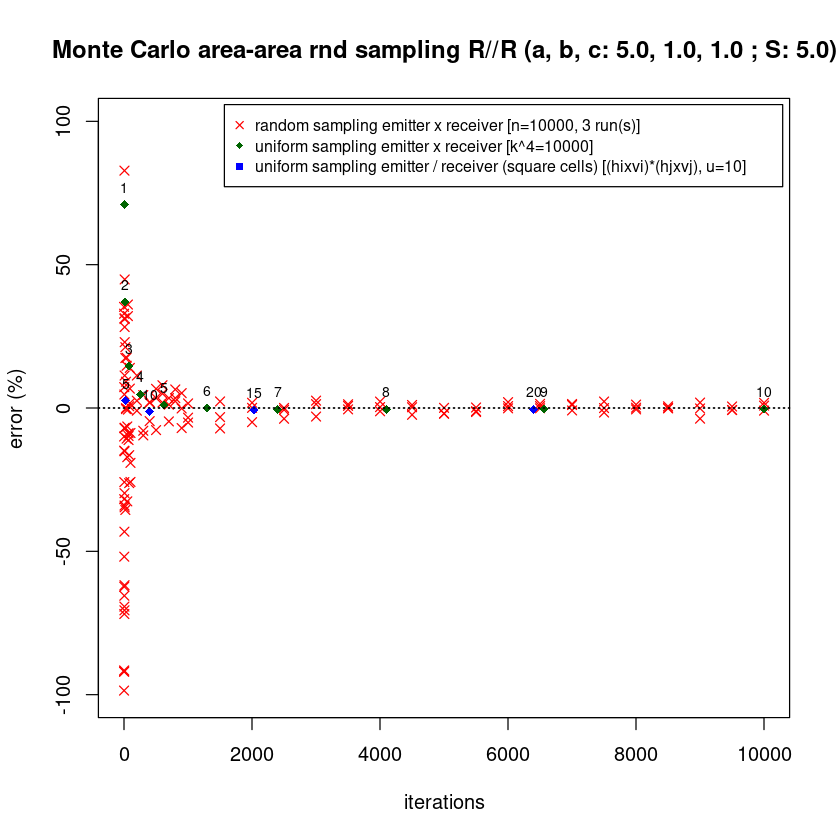

In [62]:
# a, b, c, n (random iterations), % (ymin, ymax), runs (random iter.)
go_para(5., 1., 1., 10000, 100, 3)

[1] "Analytic Fij = 3.591665e-01"
[1] "rnd (n=10000) Fij=3.611564e-01"
[1] "rnd (n=10000) Fij=3.652421e-01"
[1] "rnd (n=10000) Fij=3.563555e-01"
[1] "Analytic Fij = 3.591665e-01"
[1] "grid (1 x 1 : 1) Fij=6.141305e-01"
[1] "grid (2 x 2 : 16) Fij=4.916903e-01"
[1] "grid (3 x 3 : 81) Fij=4.118206e-01"
[1] "grid (4 x 4 : 256) Fij=3.762640e-01"
[1] "grid (5 x 5 : 625) Fij=3.629981e-01"
[1] "grid (6 x 6 : 1296) Fij=3.586767e-01"
[1] "grid (7 x 7 : 2401) Fij=3.575431e-01"
[1] "grid (8 x 8 : 4096) Fij=3.574346e-01"
[1] "grid (9 x 9 : 6561) Fij=3.576073e-01"
[1] "grid (10 x 10 : 10000) Fij=3.578254e-01"
[1] "Analytic Fij = 3.591665e-01"
[1] "grid (5 x 1 : 25) Fij=3.685599e-01"
[1] "grid (10 x 2 : 400) Fij=3.544456e-01"
[1] "grid (15 x 3 : 2025) Fij=3.567074e-01"
[1] "grid (20 x 4 : 6400) Fij=3.577207e-01"
[1] "grid (25 x 5 : 15625) Fij=3.582230e-01"
[1] "grid (30 x 6 : 32400) Fij=3.585044e-01"
[1] "grid (35 x 7 : 60025) Fij=3.586771e-01"
[1] "grid (40 x 8 : 102400) Fij=3.587903e-01"
[1] "grid 

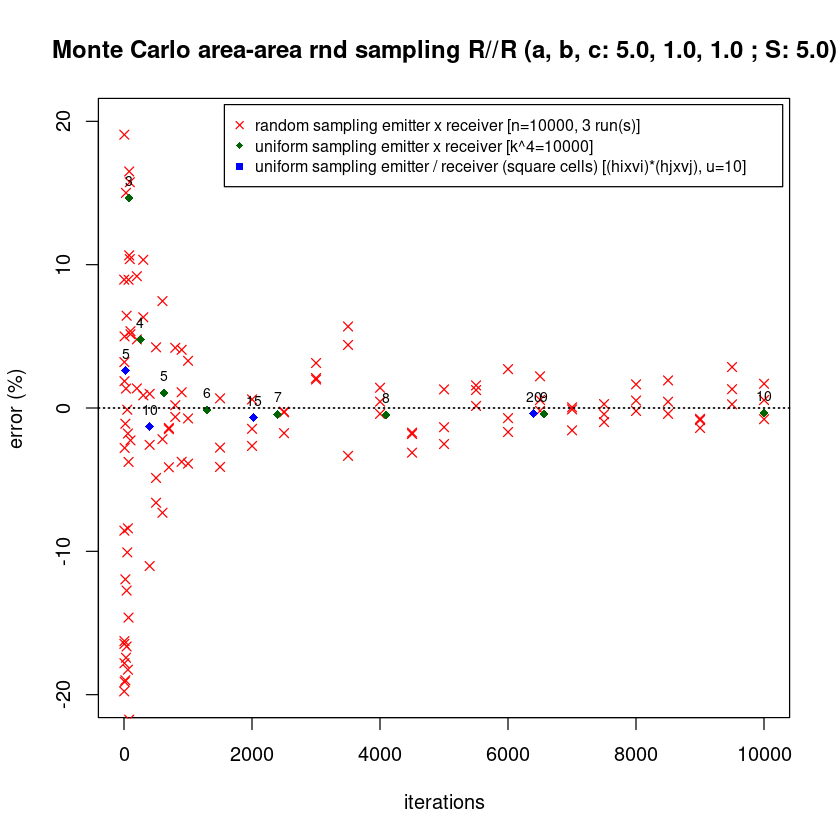

In [63]:
# a, b, c, n (random iterations), % (ymin, ymax), runs (random iter.)
go_para(5., 1., 1., 10000, 20, 3)

## Rectangle perpendiculaire à Rectangle

- Deux rectangles perpendiculaires par leur coté c sur l'axe des y.
- Ri Receveur, dans le plan (xOy) b sur x, c sur y
- Rj Emetteur, dans le plan (yOz) a sur z, c sur y

On cherche à déterminer le facteur de forme entre Ri et Rj.

### Résolution théorique

In [41]:
p_getAnalyticSolution <- function(a, b, c) {
  # Fij Théorique entre 2 faces rectangulaires identiques et parallèles (parallèle au plan (xOy)) et séparée par une distance de lz
  H = a/c
  W = b/c
  
  th_fij = (1/(pi*W)) * ( W*atan(1/W) + H*atan(1/H) - sqrt(H^2+W^2)*atan(1/sqrt(H^2+W^2))
                        + (1/4) * log( ((1+W^2)*(1+H^2)/ (1+W^2+H^2)) 
                                       * ((W^2*(1+W^2+H^2))/((1+W^2)*(W^2+H^2)))^(W^2)
                                       * ((H^2*(1+W^2+H^2)) / ((1+H^2)*(H^2+W^2)))^(H^2)
                                       ))

  msg <- sprintf("Analytic Fij = %e", th_fij)
  print(msg)
  return(th_fij)
}
print("Analytic solution 2 perpendicular rectangles along y axis: OK")

[1] "Analytic solution 2 perpendicular rectangles along y axis: OK"


### Monte Carlo: Echantillonage aléatoire par ray casting

Ici, les 2 points xi et xj sont placés aléatoirement sur chacune des surfaces Ri, Rj.

- **Attention:** test si r=|rij| == 0 Olé, olé...

In [65]:
p_compute_random <- function(a, b, c, th_fij, eaper, n, outiter, newgraph) {
  #data <- build_shapes(a, b, c)
  
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(b, c, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- b*c
  
  rj_min <- c(0., 0., 0.)
  rj_max <- c(0., c, a)
  rj_norm <- c(1., 0., 0.)
  aj <- a*c
  
  if (is.nan(th_fij)) {
    th_fij <- p_getAnalyticSolution(a, b, c)
  }
  
  mtitle <- sprintf("Monte Carlo area-area sampling RTR (a, b, c: %.1f, %.1f, %.1f ; S: %.1f;%.1f)", a, b, c, (a*c), (b*c))
  
  if (newgraph) {
    # graph y [-eaper ; eaper]
    plot(0,, type="n", xlim=c(0., n), xlab="iterations", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)
  }
  
  
  for (m in 1:outiter) {
    l <- 0
    delta <- 1
    while(l < n) {
      l <- l + delta
      delta <- getDeltaFromNbIter(l)
      fij <- 0.
      for (k in 1:l) {
        xi <- c(runif(1, ri_min[1], ri_max[1]), runif(1, ri_min[2], ri_max[2]), ri_min[3])
        r2 <- 0.
        while(r2==0.) {
            xj <- c(rj_min[1], runif(1, rj_min[2], rj_max[2]), runif(1, rj_min[3], rj_max[3]))
            rij <- xj - xi
            r2 <- sum(rij^2)
        }
        
        nrij <- rij/sqrt(r2)
        costhetai <- sum(ri_norm * nrij)
        costhetaj <- sum(rj_norm * -nrij) # dans le cas //, costhetai = costhetaj
        
        df = ( (costhetai*costhetaj) / (pi*r2 + aj/l))
        if (df > 0) {
          fij <- fij + df
        } else {
          print("df < 0")
        }
      }
      fij <- fij * aj/l
      points(x=l, y= ((fij - th_fij)/th_fij)*100., pch=4, col="red")
      #points(x=l, y=fij, pch=4, col="red")
    }
    msg <- sprintf("rnd (n=%d) Fij=%e", n, fij)
    print(msg)
  }  
  abline(h=0., col="black", lty=3)
}

print("MC Random Sampling Emitter x Receiver (n x n): OK")

[1] "MC Random Sampling Emitter x Receiver (n x n): OK"


[1] "Analytic Fij = 2.000438e-01"
[1] "rnd (n=5000) Fij=1.850410e-01"
[1] "rnd (n=5000) Fij=1.831964e-01"
[1] "rnd (n=5000) Fij=1.926729e-01"


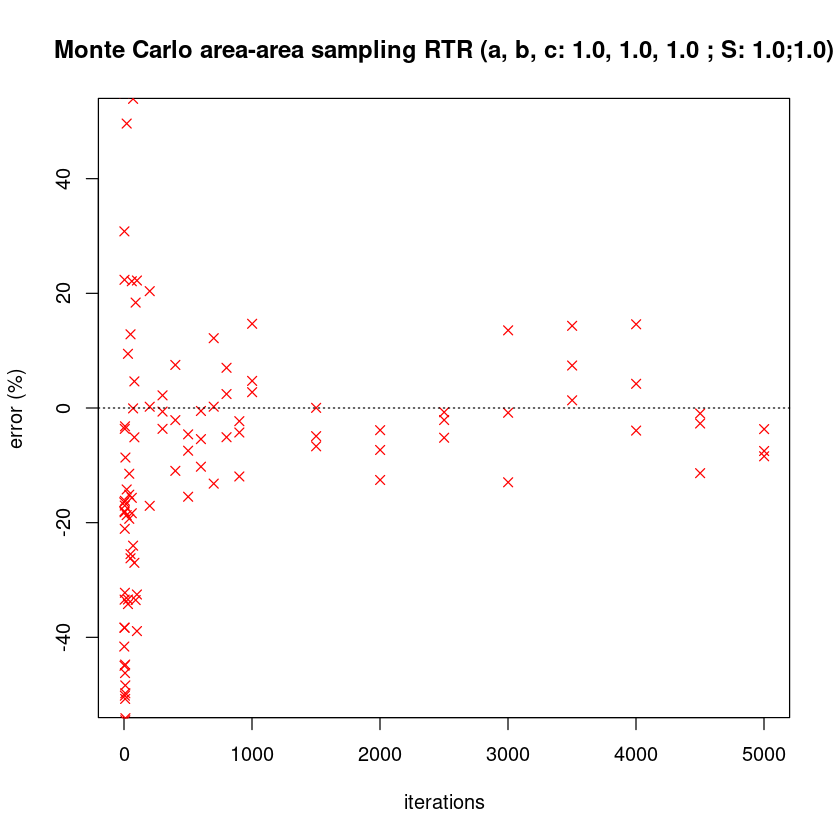

In [66]:
# a, b, c, analytic fij (Nan), graph max perc., nb iter, nb runs, 1:display new graph
p_compute_random(1., 1., 1., NaN, 50, 5000, 3, 1)

### Monte Carlo: Découpage des surfaces en cellules uniforme

- La technique est la même sauf la définition des points
- la surface des rectangles Ri et Rj est subdivisée en cellule sur leurs deux axes pour obtenir k x k surfaces. Chaque cellule conserve le ratio longueur/largeur du rectangle intial 
- le centre de chaque surface est le point de départ (ou d'arrivée) des rayons
- un rayon est émis de chaque cellule du récepteur vers chaque cellule de l'émetteur

In [44]:
p_compute_uniform_innerloop <- function(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits, pcolor="darkgreen") {
  # hypothesis a == b
  # Receiver i : y/vsplit on c ; x/hsplit on b
  
  nbsplits <- (hsplits * vsplits)^2
  db <- b/hsplits
  da <- a/hsplits
  dc <- c/vsplits
  
  a0 <- da/2.
  b0 <- db/2
  c0 <- dc/2.
  
  fij <- 0
  # on ri.y
  for (mic in 0:(vsplits-1)) {
    cic = c0 + mic * dc
    # on ri.x
    for (mib in 0:(hsplits-1)) {
      xi <- c(b0+mib*db, cic, ri_min[3])
      
      # on rj.y
      for (mjc in 0:(vsplits-1)) {
        cjc = c0 + mjc * dc
        # on rj.x
        for (mja in 0:(hsplits-1)) {
          xj <- c(rj_min[1], cjc, a0+mja*da)
          #cat("xj: ", xj,"\n")
          
          #cat("xi: ", xi, "; xj: ", xj, "\n")
          
          rij <- xj - xi
          r2 <- sum(rij^2)
          
          nrij <- rij/sqrt(r2)
          costhetai <- sum(ri_norm * nrij)
          costhetaj <- sum(rj_norm * -nrij) # dans le cas //, costhetai = costhetaj
          
          dump <- sprintf("costheta i = %f ; costheta j = %f ; r2 = %f", costhetai, costhetaj, r2)
          #print(dump)
          
          df = ( (costhetai*costhetaj) / (pi*r2 + aj/(hsplits * vsplits)))
          if (df > 0) {
            fij <- fij + df
          } else {
            print("df < 0")
          }
          
        }
      }
      
    }
  }
  fij <- fij * aj / nbsplits
  msg <- sprintf("grid (%d x %d : %d) Fij=%e", hsplits, vsplits, nbsplits, fij)
  print(msg)
  
  points(x=nbsplits, y= ((fij - th_fij)/th_fij)*100., pch=18, col=pcolor)
  text(nbsplits, ((fij - th_fij)/th_fij)*100., labels=hsplits, cex= 0.7, pos=3)
}

p_compute_uniform <- function(a, b, c, th_fij, eaper, maxsplits, newgraph) {
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(b, c, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- b*c
  
  rj_min <- c(0., 0., 0.)
  rj_max <- c(0., c, a)
  rj_norm <- c(1., 0., 0.)
  aj <- a*c
  
  if (is.nan(th_fij)) {
    th_fij <- p_getAnalyticSolution(a, b, c)
  }
  
  
  if (newgraph) {
      mtitle <- sprintf("Monte Carlo area-area Perp. - uniform - (a,b,c: %.1f,%.1f,%.1f ; S: %.1f;%.1f)", a, b, c, (a*c), (b*c))
      plot(0, type="n", xlim=c(0., maxsplits^4), xlab="splits", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)

  }
  
  for (m in 1:maxsplits) {
    hsplits <- m
    vsplits <- m
    
    p_compute_uniform_innerloop(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits)
  }

  abline(h=0., col="black", lty=3)
}
print("MC Uniform Sampling Emitter x Receiver (k^4): OK")

[1] "MC Uniform Sampling Emitter x Receiver (k^4): OK"


[1] "Analytic Fij = 2.000438e-01"
[1] "grid (1 x 1 : 1) Fij=1.944923e-01"
[1] "grid (2 x 2 : 16) Fij=1.912871e-01"
[1] "grid (3 x 3 : 81) Fij=1.919043e-01"
[1] "grid (4 x 4 : 256) Fij=1.928775e-01"
[1] "grid (5 x 5 : 625) Fij=1.937335e-01"
[1] "grid (6 x 6 : 1296) Fij=1.944352e-01"
[1] "grid (7 x 7 : 2401) Fij=1.950074e-01"
[1] "grid (8 x 8 : 4096) Fij=1.954783e-01"
[1] "grid (9 x 9 : 6561) Fij=1.958710e-01"
[1] "grid (10 x 10 : 10000) Fij=1.962026e-01"


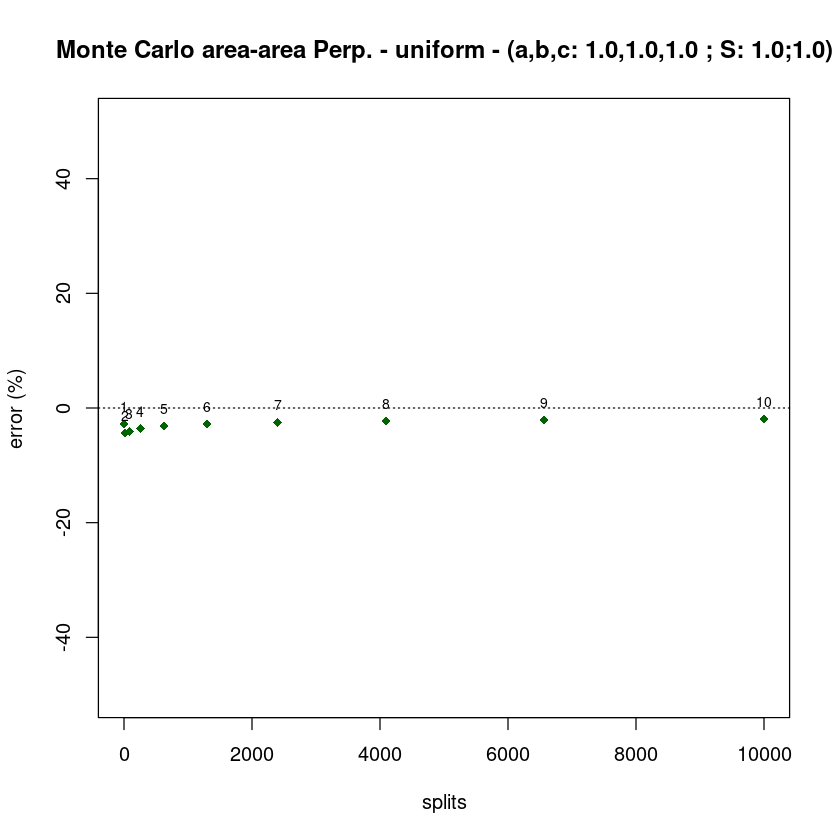

In [45]:
# a, b, c, th fij (Nan), graph max perc., k (hsplit, vsplit on both shape), 1: new graph
p_compute_uniform(1., 1., 1., NaN, 50, 10, 1)

### Monte Carlo: Découpage des surfaces en cellules carrées

- on calcule pac et pbc le pgcd de (a, c) et (b, c) puis on divise la surface en carré c et c'
- les points xi et xj seront les centres des carrés obtenus


In [68]:
p_compute_uniform_innerloop2 <- function(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits, hsplits2, vsplits2, pcolor="darkgreen") {
  # hypothesis a == b
  # Receiver i : y/vsplit on c ; x/hsplit on b
  
  nbsplits <- (hsplits * vsplits)*(hsplits2*vsplits2)
  db <- b/hsplits
  daj <- a/hsplits2
  dc <- c/vsplits
  dcj <- c/vsplits2
  
  aj0 <- daj/2.
  b0 <- db/2
  c0 <- dc/2.
  cj0 <- dcj/2.
  
  fij <- 0
  # on ri.y
  for (mic in 0:(vsplits-1)) {
    cic = c0 + mic * dc
    # on ri.x
    for (mib in 0:(hsplits-1)) {
      xi <- c(b0+mib*db, cic, ri_min[3])
      
      # on rj.y
      for (mjc in 0:(vsplits2-1)) {
        cjc = cj0 + mjc * dcj
        # on rj.x
        for (mja in 0:(hsplits2-1)) {
          xj <- c(rj_min[1], cjc, aj0+mja*daj)
          #cat("xi: ", xi, "; xj: ", xj, "\n")          
          rij <- xj - xi
          r2 <- sum(rij^2)
          
          nrij <- rij/sqrt(r2)
          costhetai <- sum(ri_norm * nrij)
          costhetaj <- sum(rj_norm * -nrij) # dans le cas //, costhetai = costhetaj
          
          dump <- sprintf("costheta i = %f ; costheta j = %f ; r2 = %f", costhetai, costhetaj, r2)
          #print(dump)
          
          df = ( (costhetai*costhetaj) / (pi*r2 + aj/(hsplits2 * vsplits2)))
          if (df > 0) {
            fij <- fij + df
          } else {
            print("df < 0")
          }
          
        }
      }
      
    }
  }
  fij <- fij * aj / nbsplits
  msg <- sprintf("grid (%d x %d , %d x %d : %d) Fij=%e", hsplits, vsplits, hsplits2, hsplits2, nbsplits, fij)
  print(msg)
  
  points(x=nbsplits, y= ((fij - th_fij)/th_fij)*100., pch=15, col=pcolor)
  text(nbsplits, ((fij - th_fij)/th_fij)*100., labels=hsplits, cex= 0.7, pos=3)
}

p_compute_uniform_gcd <- function(a, b, c, th_fij, eaper, u, newgraph, pcolor="darkgreen") {
  # i: receiver ; j: emitter
  ri_min <- c(0., 0., 0.)
  ri_max <- c(b, c, 0.)
  ri_norm <- c(0., 0., 1.)
  ai <- b*c
  
  rj_min <- c(0., 0., 0.)
  rj_max <- c(0., c, a)
  rj_norm <- c(1., 0., 0.)
  aj <- a*c
  
  if (is.nan(th_fij)) {
    th_fij <- p_getAnalyticSolution(a, b, c)
  }
  
  pac <- gcd(b, c)
  hs <- b / pac
  vs <- c / pac
    
  pbc <- gcd(a, c)
  hsj <- a / pbc
  vsj <- c / pbc
  
  if (newgraph) {
      mtitle <- sprintf("Monte Carlo area-area sampling uni. sqr. RTR (a, b, c: %.1f, %.1f, %.1f ; S: %.1f;%.1f)", a, b, c, (a*c), (b*c))
    plot(0, type="n", xlim=c(0., (hs*vs*u*u)*(hsj*vsj*u*u)), xlab="splits", ylim=c(-eaper, eaper), ylab="error (%)", main=mtitle)
  }
  
  
  for (v in 1:u) {
    hsplits <- v*hs
    vsplits <- v*vs
    hsplits2 <- v*hsj
    vsplits2 <- v*vsj
    #dump <- sprintf("v: %d (hs,vs)=(%f,%f) (hsplits,vsplits)=(%f,%f) (hsj, vsj)=(%f,%f) (hsplits2,vsplits2)=(%f,%f)", v, hs, vs, hsplits, vsplits, hsj, vsj, hsplits2, vsplits2)
    #print(dump)
    p_compute_uniform_innerloop2(a, b, c, ai, aj, ri_min, ri_norm, rj_min, rj_norm, th_fij, hsplits, vsplits, hsplits2, hsplits2, pcolor)
    #if (p == 1) { break }
  }

  abline(h=0., col="black", lty=3)
}

print("MC Uniform Sampling Emitter / Receiver with square cells (hi x vi x hj x vj): OK")

[1] "MC Uniform Sampling Emitter / Receiver with square cells (hi x vi x hj x vj): OK"


[1] "Analytic Fij = 2.000438e-01"
[1] "grid (1 x 1 , 1 x 1 : 1) Fij=1.944923e-01"
[1] "grid (2 x 2 , 2 x 2 : 16) Fij=1.912871e-01"
[1] "grid (3 x 3 , 3 x 3 : 81) Fij=1.919043e-01"
[1] "grid (4 x 4 , 4 x 4 : 256) Fij=1.928775e-01"
[1] "grid (5 x 5 , 5 x 5 : 625) Fij=1.937335e-01"
[1] "grid (6 x 6 , 6 x 6 : 1296) Fij=1.944352e-01"
[1] "grid (7 x 7 , 7 x 7 : 2401) Fij=1.950074e-01"
[1] "grid (8 x 8 , 8 x 8 : 4096) Fij=1.954783e-01"
[1] "grid (9 x 9 , 9 x 9 : 6561) Fij=1.958710e-01"
[1] "grid (10 x 10 , 10 x 10 : 10000) Fij=1.962026e-01"


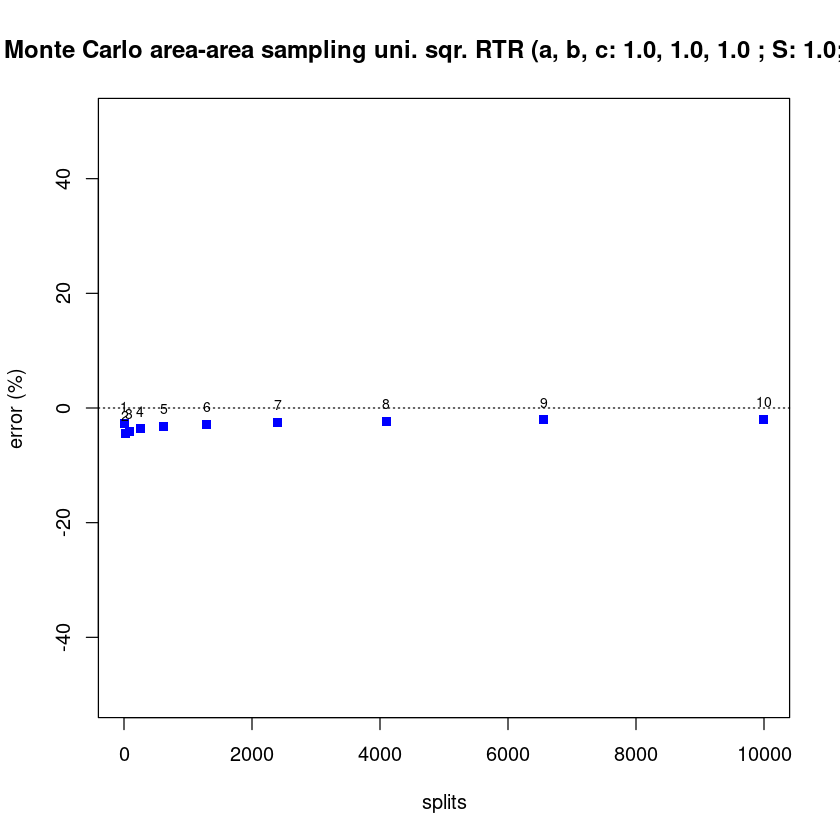

In [69]:
# a, b, c, th fij (Nan), graph max perc., k (hsplit, vsplit on both shape), 1: new graph
p_compute_uniform_gcd(1., 1., 1., NaN, 50, 10, 1, pcolor="blue")

### Quelques cas

- On note des comportements différents des algorithmes suivants le rapport entre a, b et c
- Effets importants sur la convergence quand une des valeurs devient grande par rapport aux autres

In [70]:
go_perp <- function(a, b, c, n, eaper=50, r=3) {
    p_compute_random(a, b, c, NaN, eaper, n, r, 1)
    k = as.integer(n^(1/4))
    p_compute_uniform(a, b, c, NaN, eaper, k, 0)
    p_compute_uniform_gcd(a, b, c, NaN, eaper, k, 0, pcolor="blue")
    randommsg <- sprintf("random sampling emitter x receiver [n=%d, %d run(s)]", n, r)
    uni1msg <- sprintf("uniform sampling emitter x receiver [k^4=%d]", k^4)
    uni2msg <- sprintf("uniform sampling emitter / receiver (square cells) [(hixvi)*(hjxvj), u=%d]", k)
    legend("topright", legend=c(randommsg, uni1msg, uni2msg),
         col=c("red", "darkgreen", "blue"), pch=c(4,18,15), cex=0.8, inset=0.01)
}

[1] "Analytic Fij = 2.468990e-01"
[1] "rnd (n=10000) Fij=2.206181e-01"
[1] "rnd (n=10000) Fij=2.335445e-01"
[1] "rnd (n=10000) Fij=2.657699e-01"
[1] "Analytic Fij = 2.468990e-01"
[1] "grid (1 x 1 : 1) Fij=3.782554e-02"
[1] "grid (2 x 2 : 16) Fij=1.034080e-01"
[1] "grid (3 x 3 : 81) Fij=1.500475e-01"
[1] "grid (4 x 4 : 256) Fij=1.779074e-01"
[1] "grid (5 x 5 : 625) Fij=1.946602e-01"
[1] "grid (6 x 6 : 1296) Fij=2.053298e-01"
[1] "grid (7 x 7 : 2401) Fij=2.125691e-01"
[1] "grid (8 x 8 : 4096) Fij=2.177569e-01"
[1] "grid (9 x 9 : 6561) Fij=2.216403e-01"
[1] "grid (10 x 10 : 10000) Fij=2.246485e-01"
[1] "Analytic Fij = 2.468990e-01"
[1] "grid (1 x 1 , 5 x 5 : 25) Fij=2.701278e-01"
[1] "grid (2 x 2 , 10 x 10 : 400) Fij=2.635719e-01"
[1] "grid (3 x 3 , 15 x 15 : 2025) Fij=2.593605e-01"
[1] "grid (4 x 4 , 20 x 20 : 6400) Fij=2.568049e-01"
[1] "grid (5 x 5 , 25 x 25 : 15625) Fij=2.551120e-01"
[1] "grid (6 x 6 , 30 x 30 : 32400) Fij=2.539120e-01"
[1] "grid (7 x 7 , 35 x 35 : 60025) Fij=2.530179

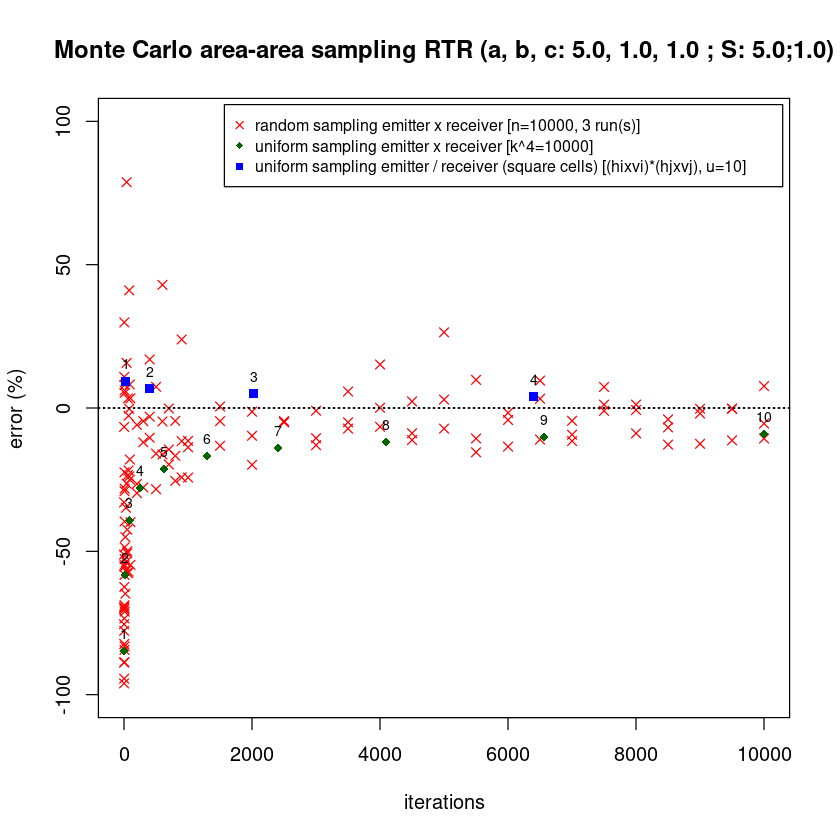

In [71]:
# a, b, c, n (random iterations), % (ymin, ymax), runs (random iter.)
go_perp(5., 1., 1., 10000, 100, 3)

[1] "Analytic Fij = 8.330388e-03"
[1] "rnd (n=10000) Fij=7.558857e-03"
[1] "rnd (n=10000) Fij=9.280558e-03"
[1] "rnd (n=10000) Fij=7.851722e-03"
[1] "Analytic Fij = 8.330388e-03"
[1] "grid (1 x 1 : 1) Fij=4.698600e-05"
[1] "grid (2 x 2 : 16) Fij=1.916331e-04"
[1] "grid (3 x 3 : 81) Fij=4.227423e-04"
[1] "grid (4 x 4 : 256) Fij=7.261396e-04"
[1] "grid (5 x 5 : 625) Fij=1.085150e-03"
[1] "grid (6 x 6 : 1296) Fij=1.482440e-03"
[1] "grid (7 x 7 : 2401) Fij=1.901652e-03"
[1] "grid (8 x 8 : 4096) Fij=2.328514e-03"
[1] "grid (9 x 9 : 6561) Fij=2.751414e-03"
[1] "grid (10 x 10 : 10000) Fij=3.161524e-03"
[1] "Analytic Fij = 8.330388e-03"
[1] "grid (30 x 1 , 1 x 1 : 30) Fij=8.184061e-03"
[1] "grid (60 x 2 , 2 x 2 : 480) Fij=8.037340e-03"
[1] "grid (90 x 3 , 3 x 3 : 2430) Fij=8.057658e-03"
[1] "grid (120 x 4 , 4 x 4 : 7680) Fij=8.090535e-03"
[1] "grid (150 x 5 , 5 x 5 : 18750) Fij=8.119367e-03"
[1] "grid (180 x 6 , 6 x 6 : 38880) Fij=8.142944e-03"
[1] "grid (210 x 7 , 7 x 7 : 72030) Fij=8.162137e

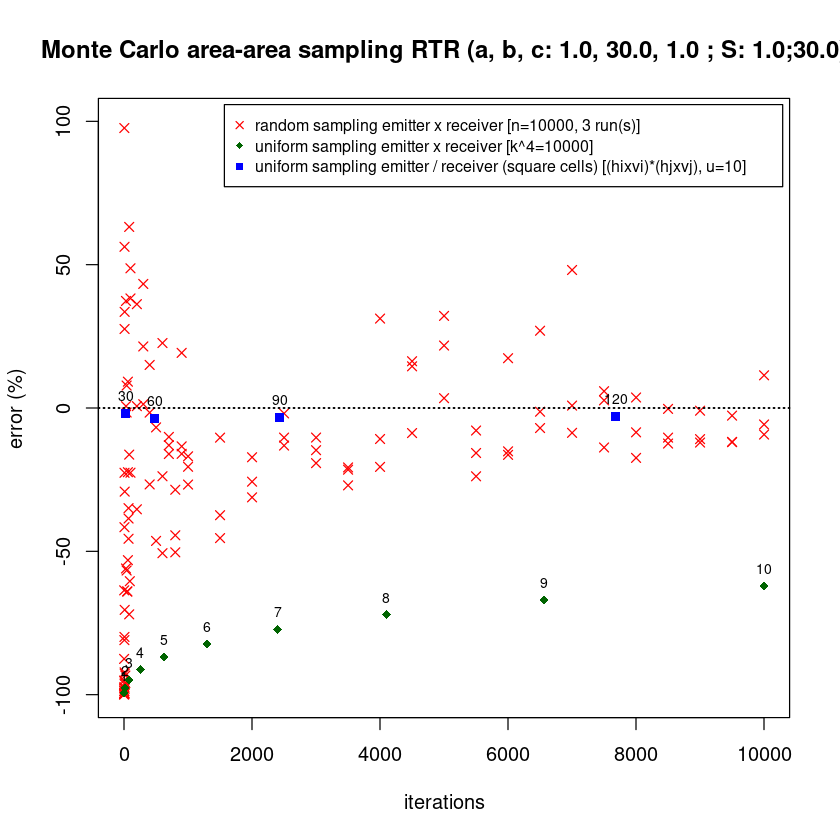

In [72]:
go_perp(1.,30., 1., 10000, 100, 3)